
## Block 1: Import Libraries

### Description:
This section imports the necessary Python libraries for data manipulation, visualization, clustering, statistical modeling, 
and survival analysis.


In [10]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import statsmodels.api as sm
from lifelines import KaplanMeierFitter

## Block 2: Directory Management

### Description:
Creates directories to store the outputs for the Per-Protocol (PP) and Intention-to-Treat (ITT) models.

### Functionality:
- `os.makedirs(PP_PATH, exist_ok=True)`: Ensures the `./models/PP/` directory exists.
- `os.makedirs(ITT_PATH, exist_ok=True)`: Ensures the `./models/ITT/` directory exists.

### Purpose:
Ensures that results from the model fitting process have a designated storage location.

In [9]:
PP_PATH = './models/PP/'
ITT_PATH = './models/ITT/'
os.makedirs(PP_PATH, exist_ok=True)
os.makedirs(ITT_PATH, exist_ok=True)

## Block 3: Load Dataset

### Description:
Loads the dataset from a CSV file and displays basic information about it.

### Steps:
1. Reads the CSV file into a pandas DataFrame (`df`).
2. Displays dataset structure using `df.info()`, `df.describe()`, and `df.head()`.

### Purpose:
Provides an overview of the dataset, helping to understand its structure and contents before analysis.

In [4]:
data_file = os.path.join('data_censored.csv')
df = pd.read_csv(data_file)

print("Dataset Overview:")
df.info()
print(df.describe())
print(df.head())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         725 non-null    int64  
 1   period     725 non-null    int64  
 2   treatment  725 non-null    int64  
 3   x1         725 non-null    int64  
 4   x2         725 non-null    float64
 5   x3         725 non-null    int64  
 6   x4         725 non-null    float64
 7   age        725 non-null    int64  
 8   age_s      725 non-null    float64
 9   outcome    725 non-null    int64  
 10  censored   725 non-null    int64  
 11  eligible   725 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 68.1 KB
               id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -0.173552    0.486897   
std     28.119313    5.

## Block 4: Data Preparation

### Description:
Defines the key column names in the dataset.

### Variables:
- `id_col`: Identifier for individuals in the dataset.
- `period_col`: Represents different time periods.
- `treatment_col`: Treatment assignment.
- `outcome_col`: Outcome variable.
- `censored_col`: Censoring indicator.
- `eligible_col`: Eligibility status.

### Purpose:
Standardizes column names to ensure consistency in later computations.

In [5]:
id_col = 'id'
period_col = 'period'
treatment_col = 'treatment'
outcome_col = 'outcome'
censored_col = 'censored'
eligible_col = 'eligible'

## Block 5: Visualizing Distributions

### Description:
Creates a histogram to visualize the age distribution in the dataset.

### Steps:
1. Uses `seaborn.histplot()` to create a histogram with a kernel density estimate (`kde`).
2. Sets the figure size to enhance readability.
3. Displays the plot with an appropriate title.

### Purpose:
Helps understand the distribution of age in the dataset, which may be relevant for clustering or modeling.

c:\Users\mikey\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


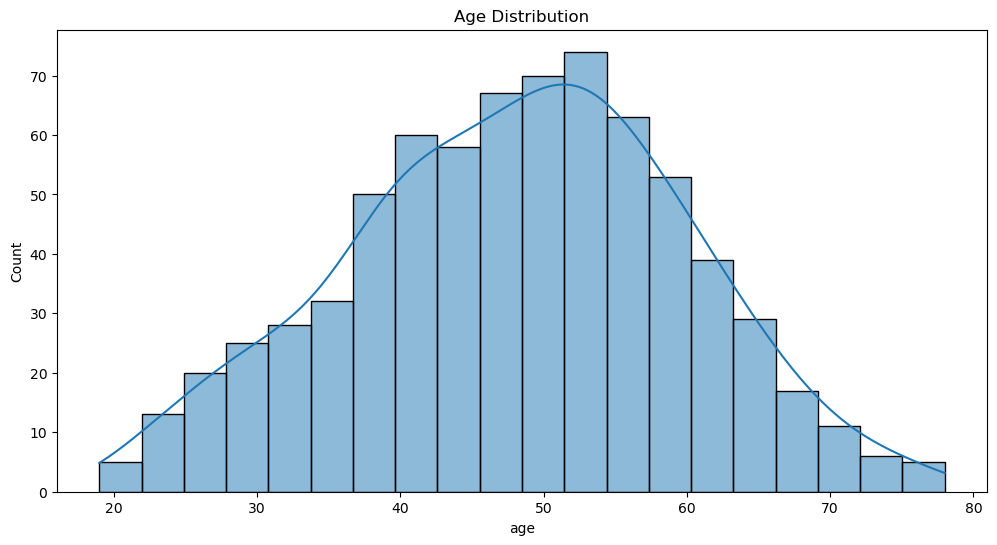

In [6]:
plt.figure(figsize=(12, 6))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

## Block 6: Weight Model Functions

### Function: `stats_glm_logit(save_path)`

### Description:
Creates a logistic regression model for calculating weights in causal inference.

### Parameters:
- `save_path` (str): Directory to save model details.

### Function: `fit_model(numerator, denominator)`

### Description:
- Saves model details, including numerator and denominator formulas, in a text file.
- Returns a dictionary containing model information.

### Returns:
- A dictionary containing model specifications and the file path.

### Purpose:
Facilitates fitting and storing logistic regression models used for Inverse Probability of Censoring Weights (IPCW).
"""

In [7]:
def stats_glm_logit(save_path):
    os.makedirs(save_path, exist_ok=True)

    def fit_model(numerator, denominator):
        model_details = {
            "numerator": numerator,
            "denominator": denominator,
            "model_type": "te_stats_glm_logit"
        }
        model_file_path = os.path.join(save_path, "model_details.txt")
        with open(model_file_path, "w") as file:
            for key, value in model_details.items():
                file.write(f"{key}: {value}\n")
        model_details["file_path"] = model_file_path
        print(f"Model details saved to {model_file_path}\n")
        return model_details

    return fit_model

## Block 7: IPCW Weight Calculation (Trial Class)

### Class: `Trial`

### Description:
This class represents a clinical trial setup where inverse probability weights are computed.

### Attributes:
- `name`: Name of the trial.
- `save_path`: Directory for storing results.
- `data`: Holds the dataset.
- `switch_weights`: Stores switch weight model details.
- `censor_weights`: Stores censor weight model details.

### Methods:
1. `set_data()`: Assigns dataset columns.
2. `set_switch_weight_model()`: Defines a model for treatment switching weights.
3. `set_censor_weight_model()`: Defines a model for censoring weights.
4. `display_weight_models()`: Prints the details of the weight models.

### Purpose:
Manages the data and models used for causal inference via inverse probability weighting.

In [8]:
class Trial:
    def __init__(self, name, save_path):
        self.name = name
        self.save_path = save_path
        self.data = None
        self.switch_weights = None
        self.censor_weights = None
        self.weights = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
        self.data = {
            "data": data,
            "id": id_col,
            "period": period_col,
            "treatment": treatment_col,
            "outcome": outcome_col,
            "eligible": eligible_col,
        }
        print(f"Data set for {self.name} trial.")
        return self

    def set_switch_weight_model(self, numerator, denominator, model_fitter):
        self.switch_weights = model_fitter(numerator, denominator)
        print(f"Switch weight model set for {self.name}")
        return self

    def set_censor_weight_model(self, censor_event, numerator, denominator, model_fitter):
        self.censor_weights = model_fitter(numerator, denominator)
        print(f"Censor weight model set for {self.name}")
        return self

    def display_weight_models(self):
        print("## Weight Models for Informative Censoring")
        print("## ---------------------------------------\n")

        if self.switch_weights:
            print("## [Switch Model]")
            print(f"Numerator: {self.switch_weights['numerator']}")
            print(f"Denominator: {self.switch_weights['denominator']}")
            print(f"Model type: {self.switch_weights['model_type']}")
            print(f"Model saved at: {self.switch_weights['file_path']}\n")
        else:
            print("No switch weight model set.\n")

        if self.censor_weights:
            print("## [Censor Weight Model]")
            print(f"Numerator: {self.censor_weights['numerator']}")
            print(f"Denominator: {self.censor_weights['denominator']}")
            print(f"Model type: {self.censor_weights['model_type']}")
            print(f"Model saved at: {self.censor_weights['file_path']}\n")
        else:
            print("No censor weight model set.\n")

Block 8: Initialize and Configure Trials

### Description:
Creates two instances of the `Trial` class for:
1. Per-Protocol (PP) analysis.
2. Intention-to-Treat (ITT) analysis.

### Steps:
1. Initializes `Trial` objects with dataset and storage paths.
2. Sets up switch weight models.
3. Sets up censor weight models.

### Purpose:
Prepares data and models for causal inference estimation.

In [11]:
trial_pp = Trial("Per-Protocol", PP_PATH).set_data(df, id_col, period_col, treatment_col, outcome_col, eligible_col)
trial_itt = Trial("Intention-to-Treat", ITT_PATH).set_data(df, id_col, period_col, treatment_col, outcome_col, eligible_col)

# Set models for switch and censor weights
model_fitter = stats_glm_logit(PP_PATH)
trial_pp.set_switch_weight_model("treatment ~ x1 + x2", "~ x1 + x2", model_fitter)
trial_pp.set_censor_weight_model("censored", "~ x1 + x2", "~ x1 + x2", model_fitter)

# Display weight models
trial_pp.display_weight_models()

Data set for Per-Protocol trial.
Data set for Intention-to-Treat trial.
Model details saved to ./models/PP/model_details.txt

Switch weight model set for Per-Protocol
Model details saved to ./models/PP/model_details.txt

Censor weight model set for Per-Protocol
## Weight Models for Informative Censoring
## ---------------------------------------

## [Switch Model]
Numerator: treatment ~ x1 + x2
Denominator: ~ x1 + x2
Model type: te_stats_glm_logit
Model saved at: ./models/PP/model_details.txt

## [Censor Weight Model]
Numerator: ~ x1 + x2
Denominator: ~ x1 + x2
Model type: te_stats_glm_logit
Model saved at: ./models/PP/model_details.txt



## Block 9: Clustering Integration

### Description:
Applies K-Means clustering to group individuals based on selected features.

### Steps:
1. Defines a K-Means model with 3 clusters.
2. Fits the model using `x1`, `x2`, and `age`.
3. Adds the cluster labels to the dataset.
4. Visualizes clusters using a scatter plot.

### Purpose:
Incorporates clustering into the trial analysis to examine subgroup effects.

c:\Users\mikey\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\mikey\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


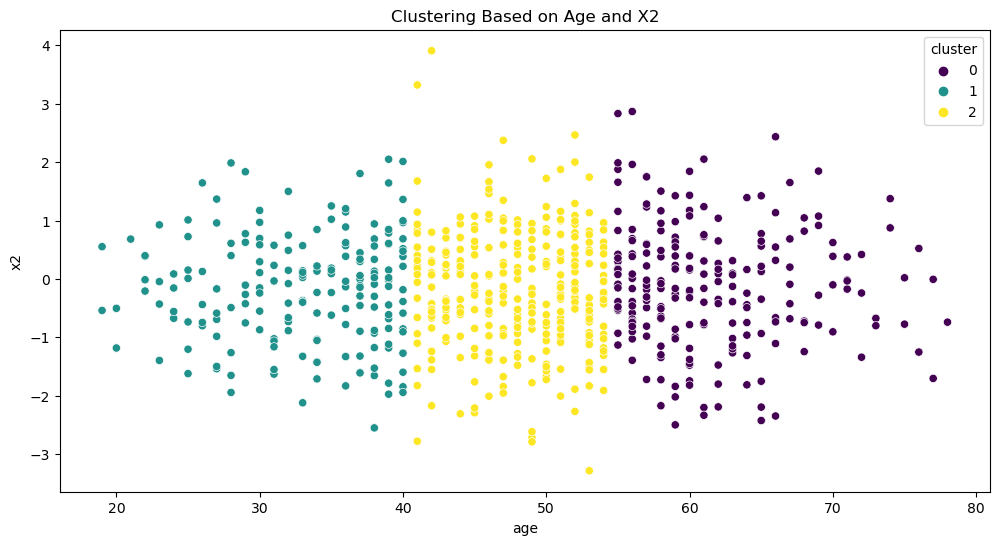

In [12]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['x1', 'x2', 'age']])
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['age'], y=df['x2'], hue=df['cluster'], palette='viridis')
plt.title('Clustering Based on Age and X2')
plt.show()

## Block 10: Expanding Trial Data

### Function: `expand_trials(data)`

### Description:
Expands the dataset by adding a `trial_period` column.

### Parameters:
- `data`: The input dataset.

### Returns:
- A modified DataFrame with the added `trial_period` column.

### Purpose:
Allows for time-stratified analysis in causal modeling.

In [16]:
def expand_trials(data):
    expanded = data.copy()
    expanded['trial_period'] = expanded[period_col]
    return expanded

df_expanded = expand_trials(df)

## Block 11: Fit Marginal Structural Model (MSM)

### Function: `fit_msm(data)`

### Description:
Fits a Marginal Structural Model (MSM) using Generalized Linear Models (GLM) to estimate causal effects.

### Parameters:
- `data` (pd.DataFrame): The dataset containing the outcome, treatment, covariates, and trial period.

### Model Specification:
- Outcome Variable: `outcome`
- Independent Variables:
  - `treatment`: Represents treatment assignment.
  - `x2`: A covariate.
  - `trial_period`: The period of the trial.

### Returns:
- A fitted GLM model (`result`), which includes regression coefficients and statistical summaries.

### Purpose:
Estimates causal effects while accounting for time-varying confounding.

In [14]:
def fit_msm(data):
    model = sm.GLM(data[outcome_col], sm.add_constant(data[[treatment_col, 'x2', 'trial_period']]),
                   family=sm.families.Binomial())
    result = model.fit()
    print(result.summary())
    return result

msm_result = fit_msm(df_expanded)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  725
Model:                            GLM   Df Residuals:                      721
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -55.587
Date:                Sun, 09 Mar 2025   Deviance:                       111.17
Time:                        21:34:46   Pearson chi2:                     705.
No. Iterations:                     8   Pseudo R-squ. (CS):           0.003855
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.5845      0.520     -6.889   

## Block 12: Save Outputs

### Description:
Saves processed datasets to the designated directories.

### Steps:
1. Saves the dataset with clusters and weights in the Per-Protocol directory.
2. Saves the expanded dataset in the Intention-to-Treat directory.
3. Prints confirmation messages.

### Purpose:
Ensures that the modified datasets are stored for further analysis and reproducibility.

In [15]:
df.to_csv(os.path.join(PP_PATH, 'data_with_weights_and_clusters.csv'), index=False)
df_expanded.to_csv(os.path.join(ITT_PATH, 'expanded_trials.csv'), index=False)
print("Processed data saved successfully!")

Processed data saved successfully!
